In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
df = pd.read_csv('data.csv')

## Data Cleaning

#### Handling null values

##### Recognizing null values with a value bigger than 90 (kaggle documentation)

In [20]:
df['DATE_DIED'] = [2 if row =='9999-99-99' else 1 for row in df['DATE_DIED']]
df = df.rename(columns={'DATE_DIED':'DIED'})

df = df.where(df<90)

##### Dropping null columns and filling null values with mode

In [21]:
missing_percentage = df.isna().sum() / len(df) * 100

columns_to_drop = missing_percentage[missing_percentage > 5].index
df = df.drop(columns=columns_to_drop)

print(df.isna().sum()/len(df)*100)

USMER                   0.000000
MEDICAL_UNIT            0.000000
SEX                     0.000000
PATIENT_TYPE            0.000000
DIED                    0.000000
PNEUMONIA               1.526166
AGE                     0.345517
DIABETES                0.318337
COPD                    0.286389
ASTHMA                  0.284100
INMSUPR                 0.324631
HIPERTENSION            0.296021
OTHER_DISEASE           0.481129
CARDIOVASCULAR          0.293350
OBESITY                 0.289154
RENAL_CHRONIC           0.286675
TOBACCO                 0.307083
CLASIFFICATION_FINAL    0.000000
dtype: float64


In [22]:
columns_to_fill = df.columns[df.isna().sum() > 0]
for column in columns_to_fill:
    df[column] = df[column].fillna(df[column].mode()[0])

print(df.isna().sum()/len(df)*100)
cleaned_df = df

USMER                   0.0
MEDICAL_UNIT            0.0
SEX                     0.0
PATIENT_TYPE            0.0
DIED                    0.0
PNEUMONIA               0.0
AGE                     0.0
DIABETES                0.0
COPD                    0.0
ASTHMA                  0.0
INMSUPR                 0.0
HIPERTENSION            0.0
OTHER_DISEASE           0.0
CARDIOVASCULAR          0.0
OBESITY                 0.0
RENAL_CHRONIC           0.0
TOBACCO                 0.0
CLASIFFICATION_FINAL    0.0
dtype: float64


## Data Reduction

#### Checking redundant feature

##### Using correlation matrix to display features correlation

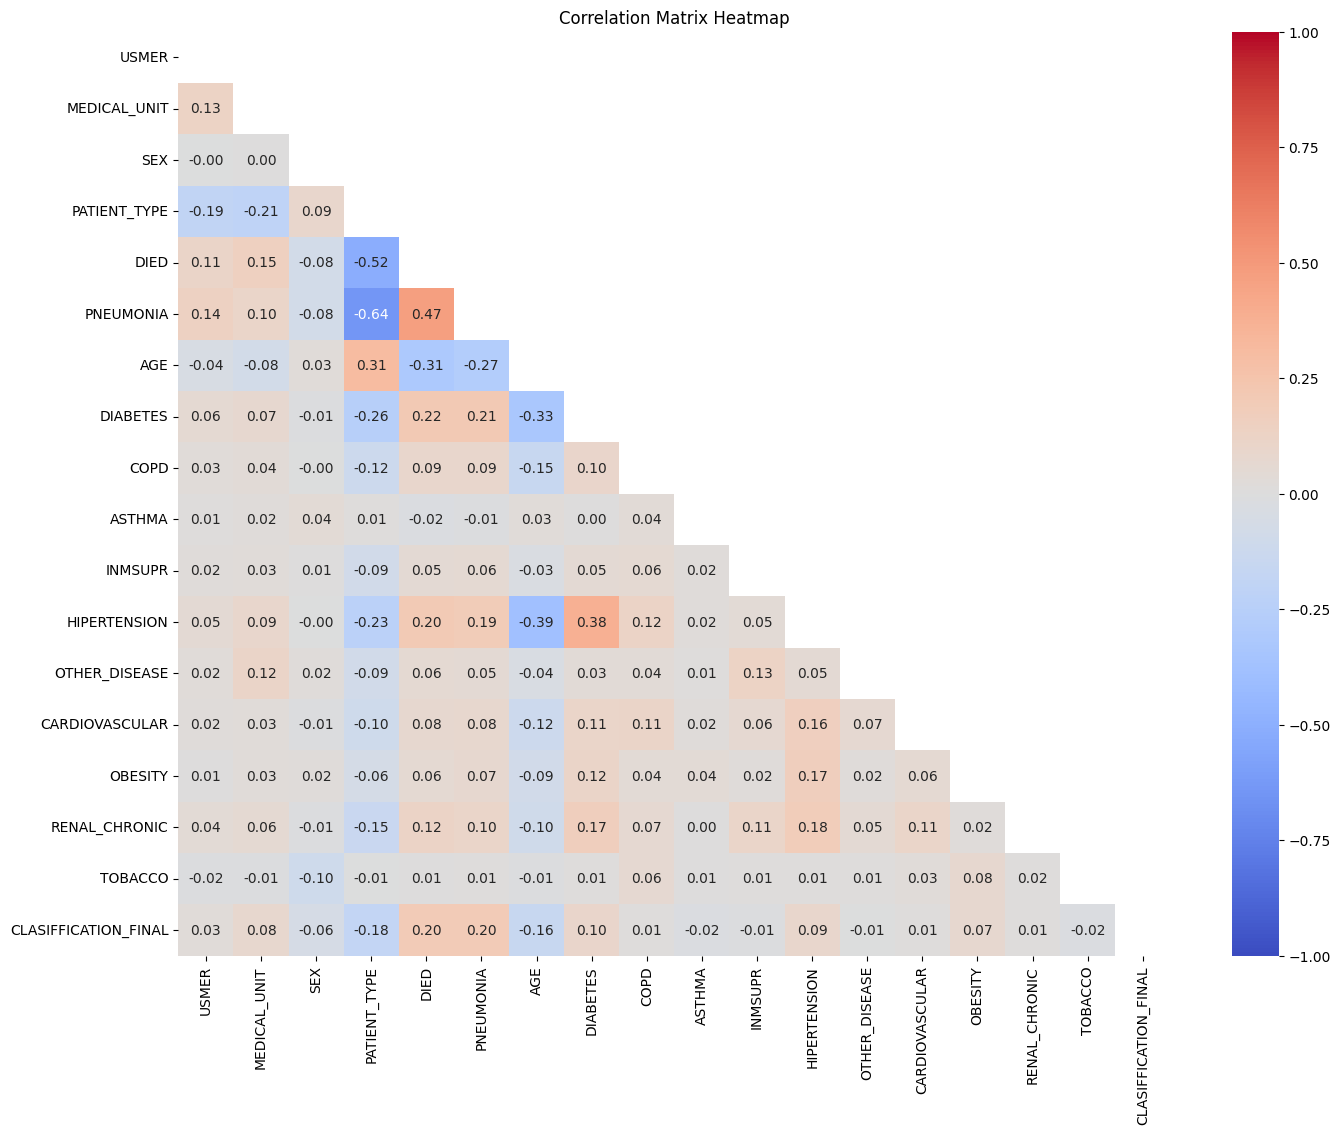

In [23]:
corr = cleaned_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))


plt.figure(figsize=(16, 12))
sns.heatmap(corr, mask=mask,annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Finding Principal Components

##### Determining the selected principal components

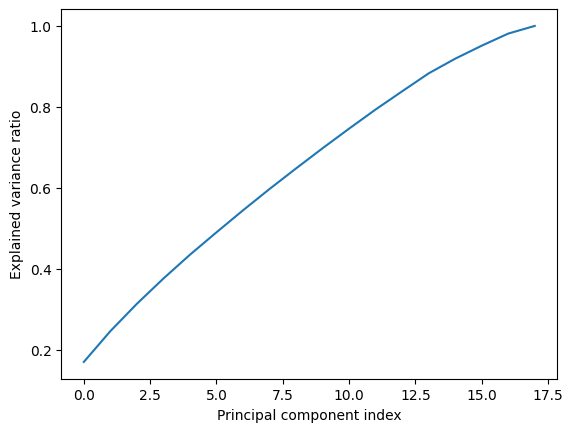

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cleaned_df)

pca = PCA()
pc = pca.fit_transform(X_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

In [27]:
cumulative_variance_ration = np.cumsum(pca.explained_variance_ratio_)
threshold_index = np.argmax(cumulative_variance_ration > 0.8)

In [29]:
selected_pc = pc[:, :threshold_index]
pc_df = pd.DataFrame(data=selected_pc, columns=[f'PC{i+1}' for i in range(threshold_index)])

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.560909  1.064194  0.452299  1.381607 -0.028510 -0.761640  0.422367   
1  5.267126 -1.404224 -0.242834 -0.169529  1.380086 -0.807845 -1.446678   
2  3.496249  1.495371  0.548305  0.246121  0.314303 -0.804619 -0.212418   
3  0.872995  0.852832 -0.669120  0.841006  0.110747 -0.105825 -0.120398   
4  3.524462 -0.404488  1.423651  0.923348  0.474144 -1.135024 -0.927819   

        PC8       PC9      PC10      PC11      PC12  
0 -0.873567  0.589175  0.894882  0.140601 -1.241591  
1  3.498165  1.184549  0.639523 -1.325102 -4.030727  
2 -0.160459  1.430651  1.313709  0.052838 -0.190863  
3 -0.906882  0.198733  1.002707  0.558260 -1.363421  
4 -0.201034  1.847541  1.772008  0.059548  0.650572  


In [ ]:
pc_df.to_csv('pca.csv', index=False)